In [1]:
!pip install prophet
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid

1685


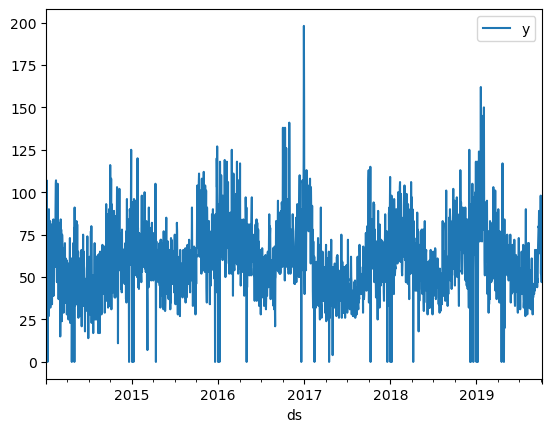

In [3]:
df = pd.read_csv("Datasets/Pharmacy/salesdaily.csv")
sales = (df.M01AB + df.M01AE + df.N02BA + df.N02BE + df.N05B + df.N05C + df.R03 + df.R06)
sales //= 1
df['sales'] = sales
df = df[["datum","sales"]]

df.columns=['ds','y']
df.dropna(inplace=True)
df['ds']=pd.to_datetime(df.ds)
df.plot(x='ds',y='y')

l = len(df)
#2106
dist = round(l*0.8)
train=df[:dist]
test=df[dist:]
print(dist)

In [4]:
#Experiment to drop outliers
# Assuming df is your DataFrame and 'column_name' is the column you're examining
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

<Axes: xlabel='ds'>

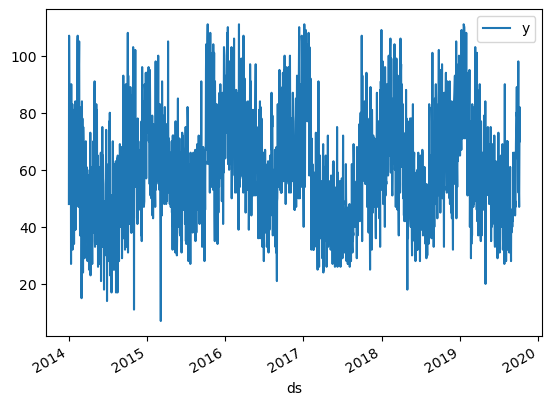

In [8]:
l = len(df_filtered)
#2106
dist = round(l*0.8)
train=df_filtered[:dist]
test=df_filtered[dist:]
df_filtered.plot(x='ds',y='y')

In [9]:
final_model=Prophet(daily_seasonality=True, changepoint_prior_scale = 0.4, holidays_prior_scale = 0.5, n_changepoints = 100, seasonality_mode = 'multiplicative')
final_model.fit(train)

future=final_model.make_future_dataframe(periods=len(test),freq='D')
forecast=final_model.predict(future)

14:05:05 - cmdstanpy - INFO - Chain [1] start processing
14:05:08 - cmdstanpy - INFO - Chain [1] done processing


<Axes: xlabel='ds'>

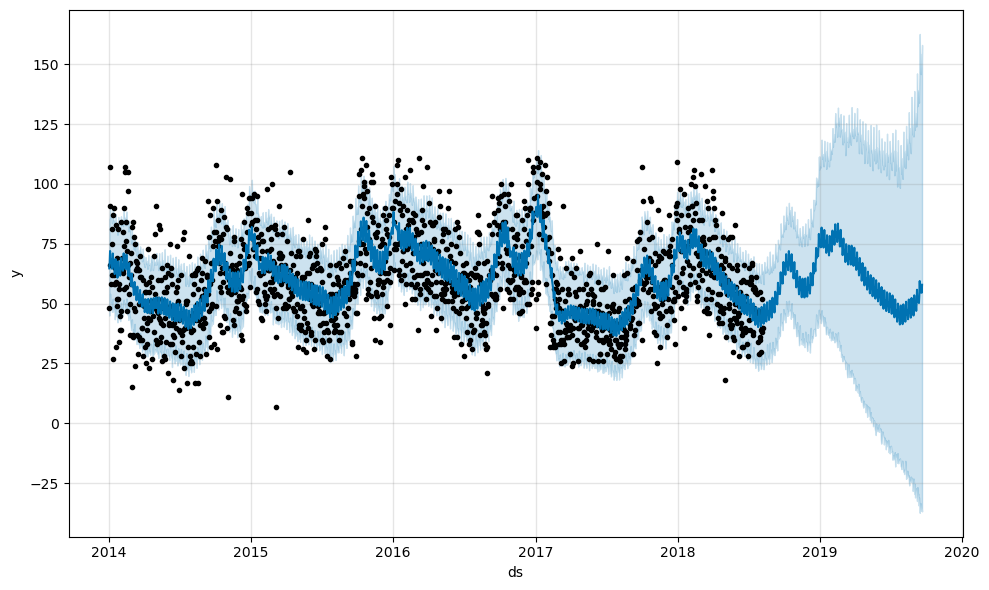

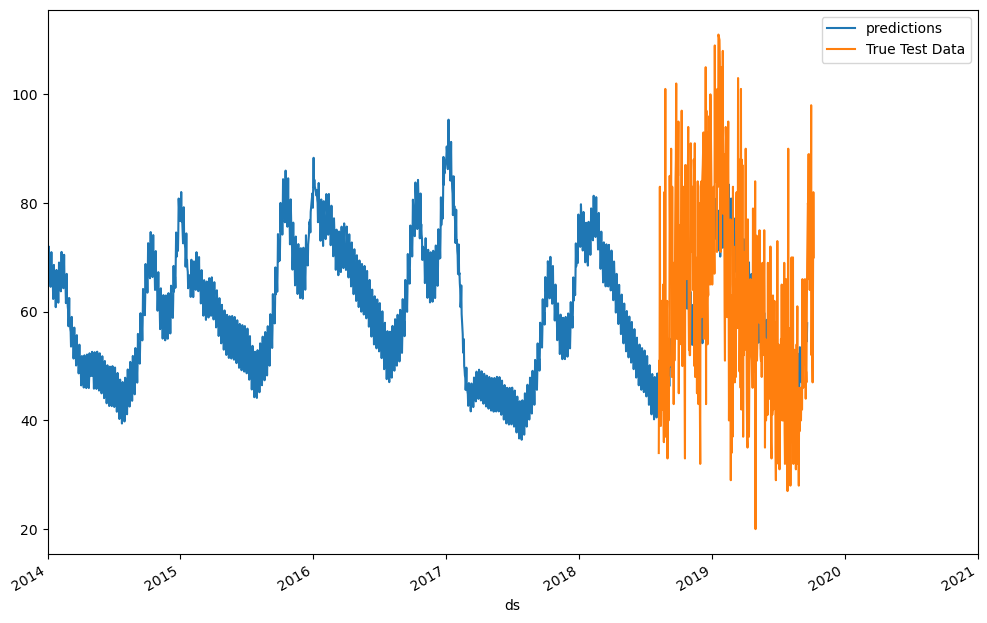

In [10]:
final_model.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2014-01-01','2021-01-01'))

In [13]:
MAE = mean_absolute_error(df_filtered['y'], forecast['yhat'])
MAE

11.898951908869147

In [15]:
para_forecast=forecast[len(train):]
MAE = mean_absolute_error(test['y'], para_forecast['yhat'])
MAE

13.887067035645016

In [29]:
import pandas as pd
import holidays

holiday = pd.DataFrame([])

for date, name in sorted(holidays.UnitedStates(years=[2014, 2015, 2016, 2017, 2018, 2019, 2020]).items()):
    # Create a DataFrame for the current holiday
    current_holiday = pd.DataFrame({'ds': [date], 'holiday': ["US-Holidays"]})
    
    # Concatenate it with the main DataFrame
    holiday = pd.concat([holiday, current_holiday], ignore_index=True)

# Convert the 'ds' column to datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5,],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [25]:
#Hypertune again:
strt='2014-1-1'
end='2019-08-10'
model_parameters = pd.DataFrame(columns=['MAE', 'Parameters'])

for p in grid:
    print(p)
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                          holidays_prior_scale=p['holidays_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          seasonality_mode=p['seasonality_mode'],
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          yearly_seasonality=True,
                          holidays=holiday, 
                          interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    
    train_forecast = train_model.make_future_dataframe(periods=len(test), freq='D', include_history=False)
    train_forecast = train_model.predict(train_forecast)
    t_test = train_forecast[['ds', 'yhat']]
    
    Actual = df_filtered[(df_filtered['ds'] > strt) & (df_filtered['ds'] <= end)]
    MAE = mean_absolute_error(test['y'], t_test['yhat'])
    print('Mean Absolute Error(MAE)------------------------------------', MAE)
    
    # Convert the parameters dictionary to a string representation for storing in DataFrame
    parameters_str = str(p)
    
    current_model_parameters = pd.DataFrame({'MAE': [MAE], 'Parameters': [parameters_str]})
    model_parameters = pd.concat([model_parameters, current_model_parameters], ignore_index=True)


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:06 - cmdstanpy - INFO - Chain [1] start processing
14:40:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.284984821270893
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.500908359229452
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:08 - cmdstanpy - INFO - Chain [1] start processing
14:40:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.10703627193901
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:40:08 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.34422926967341
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.000053898082378
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.316388160546124
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.06099303517494
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.321261069380599
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:40:13 - cmdstanpy - INFO - Chain [1] start processing
14:40:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.06236285135072
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.19900872666592
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.151518251484628
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:16 - cmdstanpy - INFO - Chain [1] start processing
14:40:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.416811483907377
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:17 - cmdstanpy - INFO - Chain [1] start processing
14:40:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.007682329874015
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:40:18 - cmdstanpy - INFO - Chain [1] start processing
14:40:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.38750344853525
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:40:18 - cmdstanpy - INFO - Chain [1] start processing
14:40:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.112867546002374
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.35374110460357
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.076833125861047
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.310156856828618
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:40:23 - cmdstanpy - INFO - Chain [1] start processing
14:40:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.973686897518183
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:40:24 - cmdstanpy - INFO - Chain [1] start processing
14:40:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.271386015202696
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:25 - cmdstanpy - INFO - Chain [1] start processing
14:40:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.11901603608841
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.440263561961943
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.059634801287846
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:40:27 - cmdstanpy - INFO - Chain [1] start processing
14:40:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.35211592002168
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:40:28 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.985743168987684
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:40:29 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.37126366628789
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:40:30 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.970028940781756
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.308291848347524
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.818730748629092
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.256704886412026
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:34 - cmdstanpy - INFO - Chain [1] start processing
14:40:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.162055174856587
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:35 - cmdstanpy - INFO - Chain [1] start processing
14:40:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.518108412011648
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.94615258008617
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:40:37 - cmdstanpy - INFO - Chain [1] start processing
14:40:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.326810259466926
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:40:37 - cmdstanpy - INFO - Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.050977499974916
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:40:38 - cmdstanpy - INFO - Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.252396789465138
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:40:39 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.188722409844335
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.343731780400288
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:40:41 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.015083657401426
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.334809853616928
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.027073914807193
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.428505915004303
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.120819981957215
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:40:46 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.331403478071065
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:40:47 - cmdstanpy - INFO - Chain [1] start processing
14:40:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.03831885173612
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:40:48 - cmdstanpy - INFO - Chain [1] start processing
14:40:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.315516020208278
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.796584698663963
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:40:50 - cmdstanpy - INFO - Chain [1] start processing
14:40:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.297976630939097
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:40:51 - cmdstanpy - INFO - Chain [1] start processing
14:40:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.050757549348383
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:40:52 - cmdstanpy - INFO - Chain [1] start processing
14:40:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.276871944368741
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:40:53 - cmdstanpy - INFO - Chain [1] start processing
14:40:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.720838484807548
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.855232836482253
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.675640913169127
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:41:00 - cmdstanpy - INFO - Chain [1] start processing
14:41:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.840538224464105
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:41:01 - cmdstanpy - INFO - Chain [1] start processing
14:41:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.730144901314302
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:41:05 - cmdstanpy - INFO - Chain [1] start processing
14:41:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.793956919269394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:41:05 - cmdstanpy - INFO - Chain [1] start processing
14:41:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.824374925576407
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.844716974560953
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.788272378432408
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.875342075862795
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.690227737338523
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:41:18 - cmdstanpy - INFO - Chain [1] start processing
14:41:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.903834182117146
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:41:19 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.699888203342487
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.876142168193914
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.731005205787177
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:41:28 - cmdstanpy - INFO - Chain [1] start processing
14:41:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.852368151064386
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:41:29 - cmdstanpy - INFO - Chain [1] start processing
14:41:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.760376446193721
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.956771050528225
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.887564343958044
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:41:41 - cmdstanpy - INFO - Chain [1] start processing
14:41:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.827275377827508
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:41:42 - cmdstanpy - INFO - Chain [1] start processing
14:41:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.66476729363565
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.975776253365872
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.745855649256546
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.893596532684583
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.78621538822581
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.90203288691224
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:41:53 - cmdstanpy - INFO - Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.829624409057079
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:41:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.870866806932515
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:41:59 - cmdstanpy - INFO - Chain [1] start processing
14:42:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.780261534369574
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:42:05 - cmdstanpy - INFO - Chain [1] start processing
14:42:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.84743262514637
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:42:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.669287410903351
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:42:09 - cmdstanpy - INFO - Chain [1] start processing
14:42:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.041890268427501
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:42:10 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.68218037072672
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:42:13 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.909620005766346
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.796969471163766
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:42:18 - cmdstanpy - INFO - Chain [1] start processing
14:42:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.856346772630038
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:42:19 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.792773685464736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.843636563439212
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:42:25 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.865598522793281
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.833890035966128
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.68520346532057
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:42:35 - cmdstanpy - INFO - Chain [1] start processing
14:42:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.94894627525224
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:42:36 - cmdstanpy - INFO - Chain [1] start processing
14:42:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.692074372699688
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.906474557459234
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.791312076037443
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.894544718530263
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:42:45 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.842459226211027
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.911167653409448
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:42:51 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.069097534835871
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:42:53 - cmdstanpy - INFO - Chain [1] start processing
14:42:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.89021853902435
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:42:54 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.823757665504852
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.127896189241769
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:42:58 - cmdstanpy - INFO - Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.82567048725871
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.12497129192472
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:43:03 - cmdstanpy - INFO - Chain [1] start processing
14:43:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.794055594494484
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:43:08 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.14228106299382
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.750231662474645
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:43:14 - cmdstanpy - INFO - Chain [1] start processing
14:43:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.129231298290593
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:43:15 - cmdstanpy - INFO - Chain [1] start processing
14:43:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.736607544146226
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.112738800665285
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.821348946532238
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.168970764554476
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:43:27 - cmdstanpy - INFO - Chain [1] start processing
14:43:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.807857066329607
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:43:31 - cmdstanpy - INFO - Chain [1] start processing
14:43:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.177160681777883
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.758653658277689
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.190011983151416
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.787614708140453
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.144138756274517
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.73335103609625
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.143893210443606
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.813469381661402
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.187949329583388
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:43:54 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.872137254152806
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:43:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.1966410457077
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.756542270269016
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:44:04 - cmdstanpy - INFO - Chain [1] start processing
14:44:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.15805223993351
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.772480138955489
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:44:11 - cmdstanpy - INFO - Chain [1] start processing
14:44:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.19255976444813
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.725728912526463
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:44:18 - cmdstanpy - INFO - Chain [1] start processing
14:44:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.181723226513055
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:44:19 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.82003681283029
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.200258579134923
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:44:23 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.797477638784718
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.201528969195454
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:44:28 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.744117044182907
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.211034537194555
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:44:34 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.724747388872753
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.192991710225412
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:44:40 - cmdstanpy - INFO - Chain [1] start processing
14:44:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.699343254056748
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:44:46 - cmdstanpy - INFO - Chain [1] start processing
14:44:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.184879080533204
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.821139247082401
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.203753239087709
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.766539103627286
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:44:56 - cmdstanpy - INFO - Chain [1] start processing
14:44:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.185953132720732
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:44:57 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.757504092698298
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.262036876902807
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:45:03 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.746377909798401
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:45:08 - cmdstanpy - INFO - Chain [1] start processing
14:45:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.182132391214976
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:45:09 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.701821995904231
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.188967653372602
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:45:16 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.866589869499125
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:45:19 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.332837620793356
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.935363369191002
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.358699746021362
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.867246551458793
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:45:30 - cmdstanpy - INFO - Chain [1] start processing
14:45:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.344366678477643
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:45:31 - cmdstanpy - INFO - Chain [1] start processing
14:45:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.845827925311433
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:45:37 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.338049047139084
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:45:38 - cmdstanpy - INFO - Chain [1] start processing
14:45:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.827152930200407
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:45:44 - cmdstanpy - INFO - Chain [1] start processing
14:45:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.36852193540017
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:45:45 - cmdstanpy - INFO - Chain [1] start processing
14:45:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.913317929229079
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:45:49 - cmdstanpy - INFO - Chain [1] start processing
14:45:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.348660952487325
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:45:50 - cmdstanpy - INFO - Chain [1] start processing
14:45:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.912054869745335
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:45:54 - cmdstanpy - INFO - Chain [1] start processing
14:45:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.368979705274905
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:45:55 - cmdstanpy - INFO - Chain [1] start processing
14:45:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.842044214280312
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.391343378934646
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:46:01 - cmdstanpy - INFO - Chain [1] start processing
14:46:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.835539857334235
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:46:06 - cmdstanpy - INFO - Chain [1] start processing
14:46:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.371481563715394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:46:07 - cmdstanpy - INFO - Chain [1] start processing
14:46:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.837180223973517
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:46:14 - cmdstanpy - INFO - Chain [1] start processing
14:46:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.35034795880687
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:46:15 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.84796843616349
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:46:17 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.366081882708892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.891059079872694
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:46:22 - cmdstanpy - INFO - Chain [1] start processing
14:46:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.350289379729881
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:46:23 - cmdstanpy - INFO - Chain [1] start processing
14:46:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.847128098478795
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:46:28 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.391376156972926
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:46:29 - cmdstanpy - INFO - Chain [1] start processing
14:46:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.817150175709935
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.378773301536302
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:46:36 - cmdstanpy - INFO - Chain [1] start processing
14:46:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.855579926385671
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:46:42 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.411613986462221
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:46:43 - cmdstanpy - INFO - Chain [1] start processing
14:46:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.86326928048024
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:46:47 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.388213847706847
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:46:48 - cmdstanpy - INFO - Chain [1] start processing
14:46:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.889719740414188
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:46:52 - cmdstanpy - INFO - Chain [1] start processing
14:46:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.395585437906085
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:46:53 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.859214289849813
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:46:58 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.38856254095212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:46:59 - cmdstanpy - INFO - Chain [1] start processing
14:47:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.821553750177477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:47:05 - cmdstanpy - INFO - Chain [1] start processing
14:47:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.391282150192328
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:47:06 - cmdstanpy - INFO - Chain [1] start processing
14:47:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.824002189864682
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:47:12 - cmdstanpy - INFO - Chain [1] start processing
14:47:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.39772053555413
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.837986884117516
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:47:16 - cmdstanpy - INFO - Chain [1] start processing
14:47:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.417503803403147
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.891835922092316
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:47:21 - cmdstanpy - INFO - Chain [1] start processing
14:47:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.416710014967656
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:47:22 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.80627538279195
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:47:25 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.372385804391019
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:47:26 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.885608835181634
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.396022733056588
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.82965075831779
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:47:39 - cmdstanpy - INFO - Chain [1] start processing
14:47:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.429503388082964
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:47:40 - cmdstanpy - INFO - Chain [1] start processing
14:47:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.917446176825797
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:47:44 - cmdstanpy - INFO - Chain [1] start processing
14:47:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.239360161596188
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:47:45 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.927451079690455
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.172769160265629
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:47:49 - cmdstanpy - INFO - Chain [1] start processing
14:47:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.897442050736053
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:47:54 - cmdstanpy - INFO - Chain [1] start processing
14:47:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.339364145389835
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:47:55 - cmdstanpy - INFO - Chain [1] start processing
14:48:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.901301977358978
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.204468334716815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.864087599923712
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.226996850419354
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.920936581330844
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:48:14 - cmdstanpy - INFO - Chain [1] start processing
14:48:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.180735255709186
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:48:15 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.913278944151786
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.147557915640698
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:48:20 - cmdstanpy - INFO - Chain [1] start processing
14:48:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.995380393803593
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.26874886545167
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:48:26 - cmdstanpy - INFO - Chain [1] start processing
14:48:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.917791592540674
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:48:32 - cmdstanpy - INFO - Chain [1] start processing
14:48:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.261684281176944
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:48:33 - cmdstanpy - INFO - Chain [1] start processing
14:48:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.889961465509597
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:48:39 - cmdstanpy - INFO - Chain [1] start processing
14:48:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.165970044863103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:48:41 - cmdstanpy - INFO - Chain [1] start processing
14:48:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.995511491423663
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:48:44 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.242658939785914
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.962751015741523
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:48:50 - cmdstanpy - INFO - Chain [1] start processing
14:48:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.197424254691061
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:48:51 - cmdstanpy - INFO - Chain [1] start processing
14:48:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.893436108905302
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:48:56 - cmdstanpy - INFO - Chain [1] start processing
14:48:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.217659267990012
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:48:57 - cmdstanpy - INFO - Chain [1] start processing
14:49:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.885897710689994
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.288573247680853
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:49:04 - cmdstanpy - INFO - Chain [1] start processing
14:49:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.898064467769778
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:49:09 - cmdstanpy - INFO - Chain [1] start processing
14:49:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.226767749845834
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:49:11 - cmdstanpy - INFO - Chain [1] start processing
14:49:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.863982176500967
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:49:13 - cmdstanpy - INFO - Chain [1] start processing
14:49:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.462355009652878
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:49:14 - cmdstanpy - INFO - Chain [1] start processing
14:49:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.929142682484294
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.34522924929353
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:49:19 - cmdstanpy - INFO - Chain [1] start processing
14:49:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.997173110017766
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:49:24 - cmdstanpy - INFO - Chain [1] start processing
14:49:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.309338066816686
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:49:25 - cmdstanpy - INFO - Chain [1] start processing
14:49:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.893505390721833
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:49:31 - cmdstanpy - INFO - Chain [1] start processing
14:49:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.246980103390218
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:49:32 - cmdstanpy - INFO - Chain [1] start processing
14:49:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.877701678522858
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:49:38 - cmdstanpy - INFO - Chain [1] start processing
14:49:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.227907953517791
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:49:40 - cmdstanpy - INFO - Chain [1] start processing
14:49:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.876826244841261
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:49:42 - cmdstanpy - INFO - Chain [1] start processing
14:49:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.247172987335267
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:49:43 - cmdstanpy - INFO - Chain [1] start processing
14:49:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.89672397136652
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.268424594893137
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:49:48 - cmdstanpy - INFO - Chain [1] start processing
14:49:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.919031895366475
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:49:53 - cmdstanpy - INFO - Chain [1] start processing
14:49:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.208902670516697
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:49:54 - cmdstanpy - INFO - Chain [1] start processing
14:49:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.97884605983143
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:50:00 - cmdstanpy - INFO - Chain [1] start processing
14:50:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.299382683118573
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:50:01 - cmdstanpy - INFO - Chain [1] start processing
14:50:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.898800591732828
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:50:08 - cmdstanpy - INFO - Chain [1] start processing
14:50:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.346064991005356
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.176506124778825
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:50:12 - cmdstanpy - INFO - Chain [1] start processing
14:50:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.706670226180492
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:50:13 - cmdstanpy - INFO - Chain [1] start processing
14:50:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.112878917400343
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:50:17 - cmdstanpy - INFO - Chain [1] start processing
14:50:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.654392367088088
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:50:19 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.092501158187357
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:50:23 - cmdstanpy - INFO - Chain [1] start processing
14:50:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.826634613788947
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:50:24 - cmdstanpy - INFO - Chain [1] start processing
14:50:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.91431584525804
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:50:29 - cmdstanpy - INFO - Chain [1] start processing
14:50:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.73165686987714
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.972445441361513
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:50:37 - cmdstanpy - INFO - Chain [1] start processing
14:50:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.656200693658437
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:50:39 - cmdstanpy - INFO - Chain [1] start processing
14:50:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.135971160203551
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:50:42 - cmdstanpy - INFO - Chain [1] start processing
14:50:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.62495870734074
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:50:43 - cmdstanpy - INFO - Chain [1] start processing
14:50:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.984107984109636
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.66883836694332
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:50:49 - cmdstanpy - INFO - Chain [1] start processing
14:50:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.98003757475617
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:50:53 - cmdstanpy - INFO - Chain [1] start processing
14:50:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.791581428335675
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:50:55 - cmdstanpy - INFO - Chain [1] start processing
14:50:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.942370264397342
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:51:00 - cmdstanpy - INFO - Chain [1] start processing
14:51:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.821407044434302
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.891796868112225
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:51:07 - cmdstanpy - INFO - Chain [1] start processing
14:51:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.6569452976732
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:51:09 - cmdstanpy - INFO - Chain [1] start processing
14:51:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.920470472565334
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:51:12 - cmdstanpy - INFO - Chain [1] start processing
14:51:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.792831256758042
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:51:13 - cmdstanpy - INFO - Chain [1] start processing
14:51:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.054568725254702
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.758964771661939
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:51:18 - cmdstanpy - INFO - Chain [1] start processing
14:51:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.050657869627564
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.776822521793804
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:51:24 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.923804714146767
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:51:29 - cmdstanpy - INFO - Chain [1] start processing
14:51:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.804055929718885
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:51:31 - cmdstanpy - INFO - Chain [1] start processing
14:51:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.946080648744594
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:51:37 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.76936947857588
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:51:39 - cmdstanpy - INFO - Chain [1] start processing
14:51:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.846577113040171
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.80333544588025
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:51:42 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.971323187004307
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.905715780147595
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.986921929319381
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.6635711515897
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:51:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.996821773744378
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.758720924098418
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:52:01 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.913149948443213
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:52:07 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.728405014646727
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:52:09 - cmdstanpy - INFO - Chain [1] start processing
14:52:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.123775430940455
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.845672605861695
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.93472429761517
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:52:18 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.706561824767945
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.957933571341314
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:52:24 - cmdstanpy - INFO - Chain [1] start processing
14:52:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.773343707489053
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:52:25 - cmdstanpy - INFO - Chain [1] start processing
14:52:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.915848355534127
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.715488269973491
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.909721800938701
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:52:38 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.793254712629318
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.246575989640355
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:52:43 - cmdstanpy - INFO - Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.430898439359074
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.091707500327724
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:52:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.388845133455009
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.093613835722877
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.329929537589802
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:52:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.092730906814
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.338313796893503
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.969917550525407
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.387702760753106
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.641381450531348
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.408808551351287
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.117749966123712
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.421439488969392
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.994251075281136
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.463811097022582
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.217385491675776
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.363810161305716
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.032239121445357
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.2, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.246505606989853
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.337143751256468
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.477716576188946
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.239885504459298
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.358015859666631
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.916249464894435
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.424699119914827
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.13666589044575
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.361618572677747
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.975049303422413
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.3, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.313432495120978
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.966520619057343
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.46279707791638
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.227737039563834
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.3520009650573
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.02937167528409
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:54:27 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.38789388298888
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.212974890072491
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.365847573781892
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:54:37 - cmdstanpy - INFO - Chain [1] start processing
14:54:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.91007225771597
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.4, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.421940601087133
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:54:44 - cmdstanpy - INFO - Chain [1] start processing
14:54:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.171260648229477
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


14:54:47 - cmdstanpy - INFO - Chain [1] start processing
14:54:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.517473930763261
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


14:54:48 - cmdstanpy - INFO - Chain [1] start processing
14:54:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.273165173737675
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


14:54:52 - cmdstanpy - INFO - Chain [1] start processing
14:54:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.371542399888003
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


14:54:53 - cmdstanpy - INFO - Chain [1] start processing
14:54:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.074143222140725
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


14:54:58 - cmdstanpy - INFO - Chain [1] start processing
14:54:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.366237204298008
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'multiplicative'}


14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.93097166480608
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 250, 'seasonality_mode': 'additive'}


14:55:05 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.381657696308107
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


14:55:07 - cmdstanpy - INFO - Chain [1] start processing
14:55:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 13.989244442031945
{'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 14.379727073960705


In [26]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print(type(parameters))
parameters.head()

import ast
params_str = parameters['Parameters'].tolist()
print(params_str[0])
params = ast.literal_eval(params_str[0])
# Extracting individual variables and their values
changepoint_prior_scale = params['changepoint_prior_scale']
holidays_prior_scale = params['holidays_prior_scale']
n_changepoints = params['n_changepoints']
seasonality_mode = params['seasonality_mode']

# Printing the extracted variables and their values
print("Changepoint Prior Scale:", changepoint_prior_scale)
print("Holidays Prior Scale:", holidays_prior_scale)
print("Number of Changepoints:", n_changepoints)
print("Seasonality Mode:", seasonality_mode)

final_model=Prophet(daily_seasonality=True, changepoint_prior_scale = params['changepoint_prior_scale'], holidays_prior_scale = params['holidays_prior_scale'], n_changepoints = params['n_changepoints'], seasonality_mode = params['seasonality_mode'])
final_model.fit(train)
future=final_model.make_future_dataframe(periods=len(test),freq='D')
forecast=final_model.predict(future)

<class 'pandas.core.frame.DataFrame'>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Changepoint Prior Scale: 0.2
Holidays Prior Scale: 0.3
Number of Changepoints: 100
Seasonality Mode: multiplicative


14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:14 - cmdstanpy - INFO - Chain [1] done processing


<Axes: xlabel='ds'>

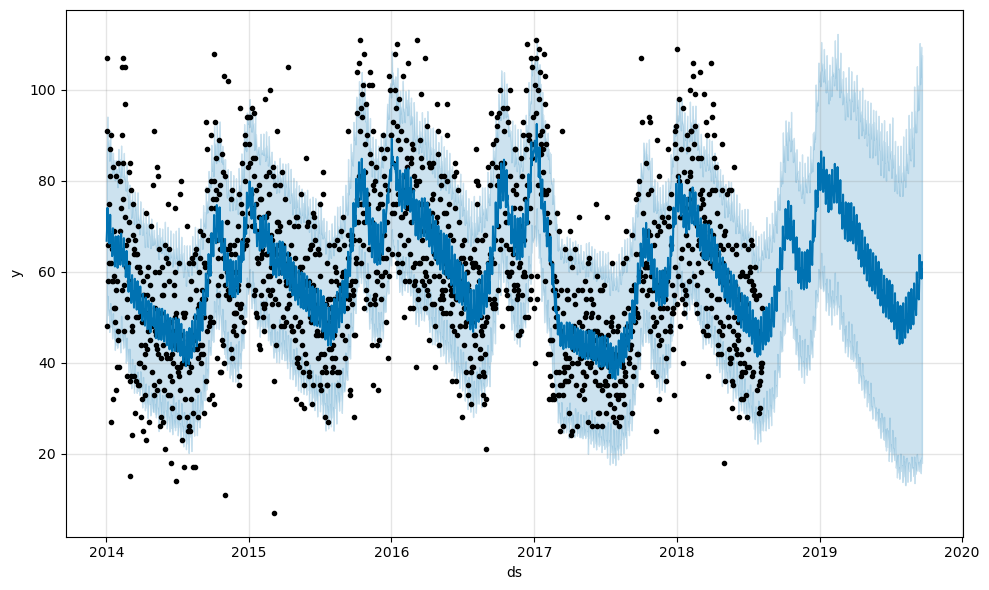

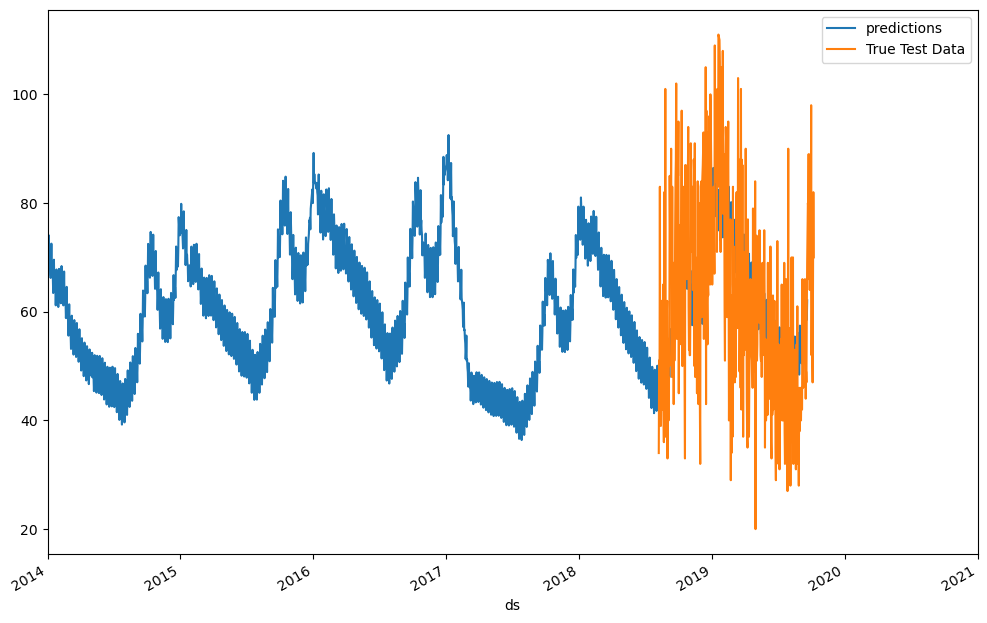

In [27]:
final_model.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2014-01-01','2021-01-01'))

In [28]:
parameters.head()

,MAE,Parameters
0,13.664767,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
1,13.669287,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
2,13.675641,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
3,13.682180,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,13.685203,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [30]:
python --version

NameError: name 'python' is not defined